In [1]:
!pip install transformers
!pip install datasets
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.7 MB/s eta 0:00:0

In [2]:
!pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.0 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import pandas as pd
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from transformers import BartTokenizer, BartForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset, load_metric
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from transformers import AutoTokenizer, LongT5ForConditionalGeneration

In [4]:
train_import = pd.read_json('/content/drive/MyDrive/NLP Project Files/Maddy/data/train.jsonl', lines = True)
test_import = pd.read_json('/content/drive/MyDrive/NLP Project Files/Maddy/data/validation.jsonl', lines = True)

train_import['tags'] = train_import['tags'].map(lambda x: x[0])
test_import['tags'] = test_import['tags'].map(lambda x: x[0])

train_import = train_import[train_import['tags'] == 'multi']
test_import = test_import[test_import['tags'] == 'multi']

train_import['spoiler'] = train_import['spoiler'].map(lambda x: ' /n/ '.join(x))
test_import['spoiler'] = test_import['spoiler'].map(lambda x:  ' /n/ '.join(x))

<ipython-input-4-9518dbfcef03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_import['spoiler'] = train_import['spoiler'].map(lambda x: ' /n/ '.join(x))


1
257


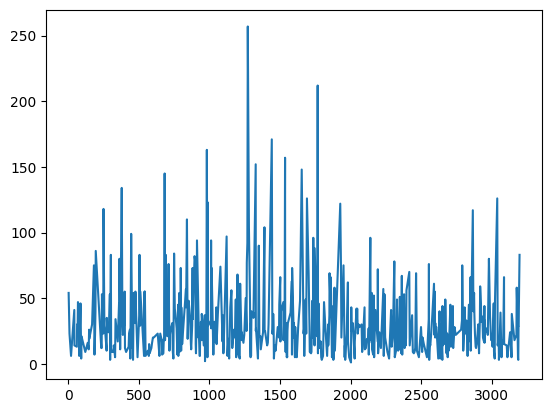

In [5]:
import matplotlib.pyplot as plt

tempo = train_import['spoiler'].apply(lambda x: len(x.split()))

plt.plot(tempo)

print(tempo.min())
print(tempo.max())

In [6]:
train_import['processedParagpraphs'] = train_import['targetParagraphs'].map(lambda x: '. '.join(x))
test_import['processedParagpraphs'] = test_import['targetParagraphs'].map(lambda x: '. '.join(x))

train_import['processedText'] = train_import['postText'].map(lambda x: x[0])
test_import['processedText'] = test_import['postText'].map(lambda x: x[0])

34
11641
531.0
1496.999999999999


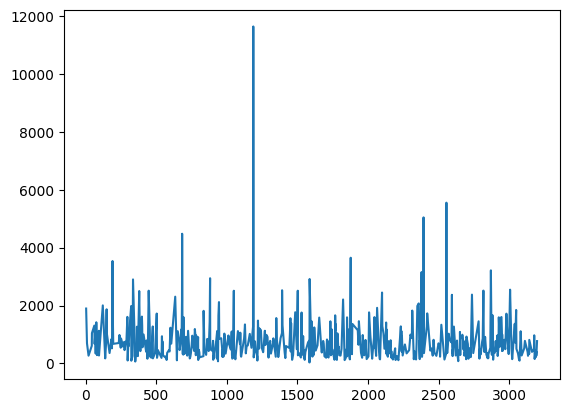

In [7]:
temp_2 = train_import['processedParagpraphs'].map(lambda x: len(x.split()))

plt.plot(temp_2)
print(temp_2.min())
print(temp_2.max())
print(temp_2.median())
print(temp_2.quantile(0.9))

In [8]:
def preprocess_data(example):
    input_text = "condition: " + example['processedText'] + " paragraph: " + example['processedParagpraphs']
    target_text = example['spoiler']
    return {"input_text": input_text, "target_text": target_text}

In [9]:
train_dataset = Dataset.from_pandas(train_import)
test_dataset = Dataset.from_pandas(test_import)

train_dataset_processed = train_dataset.map(preprocess_data)
test_dataset_processed = test_dataset.map(preprocess_data)

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

In [11]:
model_name = "google/long-t5-tglobal-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = LongT5ForConditionalGeneration.from_pretrained(model_name)

In [10]:
bleu_metric = load_metric("bleu")
meteor_metric = load_metric("meteor")
bertscore_metric = load_metric("bertscore")

<ipython-input-10-6ad6bd8f57b9>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("bleu")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [12]:
#out_1 = []
#out_2 = []

def compute_metrics(eval_pred):
    logits_full, labels = eval_pred

    #out_1.append(logits_full[0])
    #out_2.append(logits_full[1])

    predicted_token_ids = torch.argmax(torch.tensor(logits_full[0]), dim=-1).tolist()
    decoded_preds = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds_bleu = [pred.split() for pred in decoded_preds]
    decoded_labels_bleu = [[pred.split()] for pred in decoded_labels]
    
    bleu_score = bleu_metric.compute(predictions=decoded_preds_bleu, references= decoded_labels_bleu)
    meteor_score = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    bertscore_score = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang = 'en')
    
    return {"bleu": bleu_score["bleu"], "meteor": meteor_score["meteor"], "bertscore": np.mean(bertscore_score["f1"])}

In [13]:
def encode_data(batch):
    input_ids = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length= 3000, return_tensors="pt").input_ids
    target_ids = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length= 150, return_tensors="pt").input_ids
    return {"input_ids": input_ids, "labels": target_ids}

encoded_train_dataset = train_dataset_processed.map(encode_data, batched=True)
encoded_test_dataset = test_dataset_processed.map(encode_data, batched=True)

columns_to_remove = ['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs', 'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia', 'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags', 'processedParagpraphs', 'processedText', '__index_level_0__']
encoded_train_dataset = encoded_train_dataset.remove_columns(columns_to_remove)
encoded_test_dataset = encoded_test_dataset.remove_columns(columns_to_remove)


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

In [ ]:
import shutil

directory_path = f"/content/drive/MyDrive/NLP Project Files/conditional_generation/multi/results/google"
shutil.rmtree(directory_path)

In [14]:
training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/NLP Project Files/conditional_generation/multi/results/{model_name}_results",
    num_train_epochs=15,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_steps=100,
    save_steps=0,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy="epoch"

)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience= 3)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

metrics = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:816: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Meteor,Bertscore
1,13.883200,1.839034,0.657301,0.721839,0.921760
2,2.189700,0.555160,0.682049,0.755403,0.934236
3,0.532200,0.287568,0.738145,0.781544,0.944649
4,0.340400,0.219042,0.762003,0.799599,0.948345
5,0.268000,0.184485,0.776966,0.815229,0.953386
6,0.235700,0.174727,0.794075,0.838431,0.960160
7,0.217000,0.163001,0.799539,0.850402,0.962064
8,0.188400,0.157399,0.808044,0.850611,0.963001
9,0.192200,0.157086,0.808355,0.850121,0.963887
10,0.176500,0.151205,0.811050,0.854360,0.964784


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:816: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:816: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:816: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:816: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:816: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_uti

In [15]:
metrics

{'eval_loss': 0.1478436291217804,
 'eval_bleu': 0.8185876311419522,
 'eval_meteor': 0.8620208256858973,
 'eval_bertscore': 0.9657182776844585,
 'eval_runtime': 15.3806,
 'eval_samples_per_second': 9.297,
 'eval_steps_per_second': 2.341,
 'epoch': 15.0}

In [16]:
best_model_checkpoint = trainer.state.best_model_checkpoint
print(f"Best model checkpoint: {best_model_checkpoint}")


Best model checkpoint: /content/drive/MyDrive/NLP Project Files/conditional_generation/multi/results/google/long-t5-tglobal-base_results/checkpoint-2100
